In this notebook, we're going to demonstrate the use of various cadre-assessment metrics. These help us decide if a discovered cadre structure is interesting and/or stable.

When training an SCM, we're going to use optimal hyperparameters identified in `BinaryClassificationTuning.ipynb`. You should work through that notebook before looking at this one.

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '../cadreModels')

from classificationBinary import binaryCadreModel

from sklearn.model_selection import train_test_split

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_style('darkgrid')

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/HealthINCITE/cadre/master/data/df_moderate.csv')
features = data.columns[data.columns.str.contains('cad|dv') & (data.columns != 'cadre')]

In [5]:
data.head()

,cad0,cad1,cad2,cad3,cad4,cad5,cad6,cad7,cad8,cad9,cadre,dv0,dv1,dv2,dv3,dv4,target
0,0.191442,2.266938,-1.571560,-1.000071,2.575162,0.809672,-0.158311,-1.647344,0.651466,-1.060883,0,4.784785,5.177201,-4.189262,5.070376,-4.898889,1
1,-1.174611,-0.395598,-0.436501,-0.606625,0.391813,0.092166,-0.008130,1.103397,0.112093,1.117736,0,-6.783252,-4.636362,4.250647,4.624133,-5.060853,0
2,-0.415574,0.968346,0.047912,-1.216676,0.695269,-0.188202,-0.665783,2.152114,0.284394,2.169629,0,-5.179748,-4.222403,-3.925779,5.182969,-5.919294,1
3,-0.785389,0.113480,-0.186819,-0.233704,0.014695,0.727447,0.543753,2.427905,-0.961922,-0.103388,0,6.143124,4.980376,-4.985737,5.742185,-4.723161,1
4,0.377902,1.359901,0.563633,0.511998,0.411057,-0.110674,0.204616,-0.375118,0.165277,-0.627823,0,3.798002,6.331110,-5.460732,5.288602,-4.742962,1


In [6]:
features

Index(['cad0', 'cad1', 'cad2', 'cad3', 'cad4', 'cad5', 'cad6', 'cad7', 'cad8',
       'cad9', 'dv0', 'dv1', 'dv2', 'dv3', 'dv4'],
      dtype='object')

Overall training-testing split.

In [7]:
D_tr, D_te = train_test_split(data, test_size=0.2, random_state=313616)

Functions for standardization

In [8]:
def standardize_col(col, mean, std):
    return (col - mean) / std

In [9]:
def standardizer(d_tr, features, d_va=None, d_te=None):
    d_tr_scale = d_tr.copy()
    if d_va is not None:
        d_va_scale = d_va.copy()
    if d_te is not None:
        d_te_scale = d_te.copy()
    for feature in features:
        f_mean = d_tr[feature].mean()
        f_std = d_tr[feature].std()
        
        d_tr_scale[feature] = standardize_col(d_tr_scale[feature], f_mean, f_std)
        if d_va is not None:
            d_va_scale[feature] = standardize_col(d_va_scale[feature], f_mean, f_std)
        if d_te is not None:
            d_te_scale[feature] = standardize_col(d_te_scale[feature], f_mean, f_std)
        
    if d_te is not None and d_va is not None:
        return d_tr_scale, d_va_scale, d_te_scale
    elif d_va is not None:
        return d_tr_scale, d_va_scale
    elif d_te is not None:
        return d_tr_scale, d_te_scale
    else:
        return d_tr_scale

In [10]:
d_tr_sc, d_te_sc = standardizer(D_tr, features, d_te=D_te)

In [11]:
M = 6
lambda_d=0.001
lambda_W = 0.1

In [12]:
scm_best = binaryCadreModel(Tmax=2401, record=200, lambda_W=lambda_W, lambda_d=lambda_d, M=M)
scm_best.fit(d_tr_sc, 'target', features, features, d_te_sc, progress=True)

numbers being printed: SGD iteration, training loss, training accuracy, validation loss, validation accuracy, time
0
200 0.7987542 0.53625 0.8000673 0.525 0.1554274559020996
400 0.71457326 0.71625 0.71124184 0.715 5.001260757446289
600 0.69282067 0.785 0.68987256 0.77 9.861350774765015
800 0.67895895 0.81125 0.6756983 0.805 14.64006757736206
1000 0.66785467 0.815 0.664533 0.805 19.074071645736694
1200 0.6579155 0.825 0.65442586 0.825 23.324342966079712
1400 0.6503688 0.82375 0.6469892 0.845 27.615272521972656
1600 0.64359224 0.82375 0.64024884 0.85 31.837649822235107
1800 0.63741255 0.82875 0.6337153 0.865 36.219985246658325
2000 0.6319772 0.8325 0.6282441 0.87 40.72382402420044
2200 0.6266623 0.8325 0.6226094 0.875 45.25258660316467
2400 0.62190217 0.83125 0.617524 0.875 49.84610629081726
training has terminated because: model took 2401 SGD steps


An easy way to quantify the simplicity of a learned cadre structure is to examine how sparse the cadre assignment weight parameter `d` is. We plot it below.

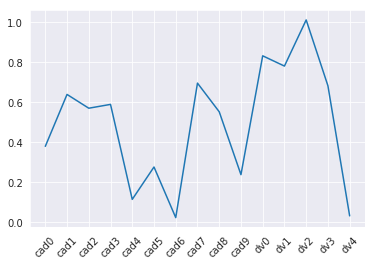

In [13]:
p = sns.lineplot(data=scm_best.d)
for item in p.get_xticklabels():
    item.set_rotation(45)

We see that the features `dv2` and `dv0` have the largest `d_p` values, indicating that changes in them are most strongly associated with changes in cadre membership. Overall, this `d` parameter is not especially sparse.

We can also calculate the conditional entropy of the cadre assignment random variable. When this is low for a given cadre (close to 0), the assignment probabilities of observations to that cadre tend to be close to 1, and cadre assignments are more confident. When it is large for a given cadre (close to `log2(M)`), assignment probabilities of observations to that cadre are less confident. More details about this use of conditional entropy may be found at `arXiv:1808.04880`.

In [14]:
pd.Series(scm_best.entropy(d_tr_sc), index=np.arange(6)).sort_values()

3    0.307827
4    0.566937
2    0.868749
1    0.874816
0    1.068803
5    1.404583
dtype: float64

In [15]:
np.log2(6)

2.584962500721156

Cadre 3 has the lowest cadre assignment conditional entropy. Overall, the entropies are fairly large.

In [16]:
scm_best.scoreMetrics(d_te_sc)

,PR_AUC,ROC_AUC,accuracy,loss
0,0.938827,0.945734,0.88,0.711054


When cadre assignments are confident, then the SCM may be treated as piecewise-linear, and inferences about associations between the target and features may be made by looking at the `W` parameter. When cadre assignments are not confident, then the SCM may be predicting the target with a generally nonlinear behavior.

One way we can force the SCM to behave in a piecewise-linear way is to increase the `gamma` parameter after training. If making this increase doesn't noticeably affect generalization accuracy, then the simpler piecewise-linear predictions are just as good as a generally nonlinear prediction. Note that changing `gamma` will never affect predicted cadre memberships, it will only sharpen cadre-assignment probabilities.

In [17]:
scm_best.gamma = 100

In [18]:
pd.Series(scm_best.entropy(d_tr_sc), index=np.arange(6)).sort_values()

3    0.037724
4    0.084783
1    0.098577
2    0.136039
0    0.137295
5    0.269282
dtype: float64

By increasing `gamma`, we've shrunk the conditional entropies.

In [19]:
scm_best.scoreMetrics(d_te_sc)

,PR_AUC,ROC_AUC,accuracy,loss
0,0.927452,0.939504,0.875,0.706822


Generalization accuracies have decreased, but not excessively.

Recall that each cadre $m$ is given a vector of weights $w^m \in \mathbb{R}^P$ quantifying the association between the target and each feature $p$. An interesting question is: How similar are each cadre's weight vector to each other? We can quantify this with an average standard deviation, implemented in the `weight_comparison` method.

This method calculates $$\frac{1}{P} \sum_{p=1}^M \text{StdDev}(w^1_p, ..., w^M_p).$$

In [20]:
scm_best.weight_comparison()

0.023537373

We can get more detail by looking at a heatmap.

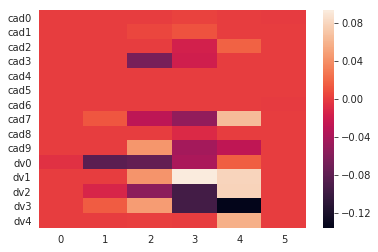

In [21]:
sns.heatmap(scm_best.W)

It seems that cadres 0 and 5 have very sparse weight vectors, and cadres 2, 3, and 4 have denser weight vectors.

The `binaryCadreModel` class has a number of methods for applying a trained model to new data.

The `predictMargin` method returns predicted classification margins for new observations. When an observation's margin is small, the observation is probably of class 0, and when it is large, the observation is probably of class 1.

In [22]:
f = scm_best.predictMargin(d_te_sc)

The `predictClass` method returns predicted labels for new observations.

In [23]:
l = scm_best.predictClass(d_te_sc)

The `predictCadre` method returns predicted cadre assignments for new observations.

In [24]:
m = scm_best.predictCadre(d_te_sc)

There's also a `predictFull` method, that, in addition to `f`, `l`, and `m`, also returns:
* `G` -- the matrix of cadre assignment probabilities for new data
* `loss` -- the value of the loss function, evaluated on the new dataset

In [25]:
f, l, G, m, loss = scm_best.predictFull(d_te_sc)

It's useful to know how stable a given cadre is. That is, if the data generation had occurred in a slightly different way, would the same observations still be assigned to the same cadres?

We can try to answer this question with bootstrapping and the average best match (ABM). More details about the ABM may be found in `arXiv:1802.02500`.

The basic idea is to take a lot of bootstrap samples of the original dataset, and then match cadres in the bootstrapped data to cadres in the original data with a score between 0 and 1. These scores are then averaged over all bootstrap samples.

Number of bootstrap samples. This is smaller than you would want to use in practice.

In [26]:
nBoot = 8

In [27]:
indices = []
data_sc = standardizer(data, features)
indices.append(pd.DataFrame({'m': scm_best.predictCadre(data_sc), 'n': np.arange(data.shape[0])}))

In [28]:
inits = {'d': scm_best.d.values,
        'C': scm_best.C.values,
        'W': scm_best.W.values,
        'W0': scm_best.W0}

Generate bootstrap samples and calculate cadre assignments.

In [29]:
for b in range(nBoot):
    print(b)
    d_boot = data.sample(frac=1, replace=True, random_state=b)
    __, d_b_sc = standardizer(data, features, d_te=d_boot)
    
    scm_boot = binaryCadreModel(Tmax=201, record=200, lambda_W=lambda_W, lambda_d=lambda_d, M=M)
    scm_boot.fit(d_b_sc, 'target', features, features)
    
    assignments = pd.DataFrame({'m': scm_best.predictCadre(d_b_sc), 'n': d_b_sc.index})
    indices.append(assignments)

0
1
2
3
4
5
6
7


For each entry of `indices`, column `'n'` is the index of that observation (in the original dataset), and column `'m'` is that observation's assigned cadre.

In [30]:
indices[0].head()

,m,n
0,2,0
1,3,1
2,2,2
3,2,3
4,2,4


Function implementing the `match` score. If two cadres have a lot of overlap (i.e., shared observations), their match score will be close to 1. As their amount of overlap decreases, their match score approaches 0.

In [31]:
def match(cadre_indices_1, cadre_indices_2):
    intersection_size = np.intersect1d(cadre_indices_1.values, cadre_indices_2.values).shape[0]
    return intersection_size * np.minimum(1 / cadre_indices_1.shape[0], 1 / cadre_indices_2.shape[0])

Define a `matches` tensor. `matches[b,m0,m1]` gives the match score between cadre `m0` in the original data and cadre `m1` in the `b`th bootstrap sample.

In [32]:
matches = np.zeros((nBoot, M, M))

In [33]:
for b in range(nBoot):
    for m0 in range(M):
        for m1 in range(M):
            matches[b,m0,m1] = match(indices[0].loc[indices[0]['m'] == m0, 'n'],
                                    indices[b+1].loc[indices[b]['m'] == m1, 'n'])

Calculate average best match for each cadre in the original dataset.

In [34]:
avg_best_match = matches.max(axis=2).mean(axis=0)

In [35]:
scm_best.scoreMetricsCadre(d_te_sc).assign(ABM = pd.Series(avg_best_match, index=np.arange(M))).sort_values('ABM', ascending=False)

,m,size,proportion,accuracy,ROC_AUC,PR_AUC,ABM
3,3,70,0.028571,0.971429,0.852941,0.128788,0.262459
4,4,43,0.837209,0.860465,0.873016,0.975188,0.206466
2,2,43,0.813953,0.813953,0.800000,0.954883,0.186832
1,1,14,0.857143,0.857143,0.666667,0.939690,0.124572
0,0,19,0.105263,0.894737,0.735294,0.350000,0.115800
5,5,11,0.545455,0.545455,0.333333,0.491703,0.068782


We see that cadre 3 has the highest average best match (ABM), indicating that it is the most stable, followed by cadres 4 and 2. We can compare these numbers to $ABM$ column of Table III in `arXiv:1802.02500` to see that the cadre structures discovered for this synthetic dataset are much less stable than those discovered in arXiv:1802.02500. To first approximation, this may be a consequence of the fairly low sample size in this dataset and the fairly high number of cadres.

Finally, we can try to get robust estimates of associations between the target and each feature within a cadre.

The procedure for this is:
* For each cadre, take many bootstrap samples of the observations assigned to that cadre
* For each bootstrap sample, train a LASSO model and extract its coefficients
* For each cadre and feature, find a 95% confidence interval for that feature's coefficients over all bootstrap samples
* Report whether than interval contains 0

In [36]:
d_tr_aug = d_tr_sc.assign(m = scm_best.predictCadre(d_tr_sc))
d_te_aug = d_te_sc.assign(m = scm_best.predictCadre(d_te_sc))
d_aug = pd.concat([d_tr_aug, d_te_aug])

In [37]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [38]:
all_coefs = np.zeros((nBoot, M, features.shape[0]))

for mm in range(M):
    data_m = d_aug.loc[d_aug['m'] == mm,:]
    ## quick cross validation to find best C
    logreg_cv = LogisticRegressionCV(penalty='l1', scoring='neg_log_loss', solver='liblinear', cv=5)
    logreg_cv.fit(data_m[features].values, data_m['target'].values)
    
    for b in range(nBoot):
        d_m_b = data_m.sample(frac=1, random_state=b, replace=True)
        log_reg = LogisticRegression(penalty='l1', solver='liblinear', C=logreg_cv.C_[0])
        log_reg.fit(d_m_b[features].values, d_m_b['target'].values)
        all_coefs[b,mm,:] = np.squeeze(log_reg.coef_)

/home/newa/.conda/envs/my_root/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/newa/.conda/envs/my_root/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Calculate the lower and upper bounds of a 95% confidence interval over the bootstrap samples.

In [39]:
quantiles = np.quantile(all_coefs, (0.025, 0.975), 0)

If `zero_status[p,m] = 1`, then the 95% confidence interval for the `p`th feature's logistic regression coefficient within the `m`th cadre did not contain 0. If `zero_status[p,m] = 0`, then the interval contained 0.

In [40]:
zero_status = np.ones((features.shape[0], M))

In [41]:
for mm in range(M):
    for p in range(features.shape[0]):
        low_bound, up_bound = quantiles[:,mm,p]
        if low_bound < 0 and up_bound > 0:
            zero_status[p,mm] = 0
zero_status = pd.DataFrame(zero_status, index=features)

Heatmap of findings. Cadre 3 has the densest model -- none of its coefficients' confidence intervals contained zero. 

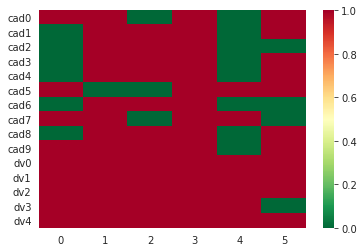

In [42]:
sns.heatmap(zero_status, cmap='RdYlGn_r')